# Instagram Analytics Project (1 notebook)

This notebook is a **single-file deliverable** to answer the teacher’s questions with a “real data analyst” workflow:

- Data loading + quality checks  
- Cleaning + feature engineering  
- Clear baselines  
- Train/test evaluation  
- Visualizations (sampled for speed)  
- Profiling + personas (clustering)  
- “Minimum information” using feature importance / selection

> Replace `DATA_PATH` with your file path (CSV/Parquet).  
> With **1M rows**, we sample for plots and heavy stats to keep it fast.


In [1]:
# 0) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
)

# sklearn version compatibility (root_mean_squared_error exists in newer versions)
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    root_mean_squared_error = None
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance

from scipy.stats import pearsonr, spearmanr

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42

# Speed settings for large datasets (1M+ rows)
SAMPLE_ROWS_MODEL = 200_000   # max rows to train heavy models
SAMPLE_ROWS_CLUSTER = 150_000 # max rows for clustering
SAMPLE_ROWS_PLOT = 5_000      # points for scatter plots             


## 1) Load data

Tip for 1M rows:
- Prefer **Parquet** if you have it (faster than CSV).
- For CSV, keep `low_memory=False` and parse dates after loading.


In [2]:
DATA_PATH = DATA_PATH = "datas/instagram_usage_lifestyle.csv" 

# CSV
df = pd.read_csv(DATA_PATH, low_memory=False)

# If parquet:
# df = pd.read_parquet(DATA_PATH)

print("Rows, Cols:", df.shape)
df.head()


Rows, Cols: (1547896, 58)


,user_id,app_name,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,has_children,exercise_hours_per_week,sleep_hours_per_night,diet_quality,smoking,alcohol_frequency,perceived_stress_score,self_reported_happiness,body_mass_index,blood_pressure_systolic,blood_pressure_diastolic,daily_steps_count,weekly_work_hours,hobbies_count,social_events_per_month,books_read_per_year,volunteer_hours_per_month,travel_frequency_per_year,daily_active_minutes_instagram,sessions_per_day,posts_created_per_week,reels_watched_per_day,stories_viewed_per_day,likes_given_per_day,comments_written_per_day,dms_sent_per_week,dms_received_per_week,ads_viewed_per_day,ads_clicked_per_day,time_on_feed_per_day,time_on_explore_per_day,time_on_messages_per_day,time_on_reels_per_day,followers_count,following_count,uses_premium_features,notification_response_rate,account_creation_year,last_login_date,average_session_length_minutes,content_type_preference,preferred_content_theme,privacy_setting_level,two_factor_auth_enabled,biometric_login_used,linked_accounts_count,subscription_status,user_engagement_score
0,1,Instagram,51,Female,India,Rural,High,Retired,Bachelor’s,Single,No,7.2,7.7,Good,No,Rarely,3,8,20.8,148,86,8107,49.9,3,4,7,4.3,0,5.0,1,3,42,28,28,5,12,12,4,1,2,1,1,2,374,647,No,0.34,2015,2025-11-02,5.0,Mixed,Tech,Private,Yes,No,0,Free,7.83
1,2,Instagram,64,Female,United Kingdom,Urban,Middle,Full-time employed,Other,Divorced,No,10.9,8.6,Very poor,No,Rarely,1,1,23.5,133,84,8059,15.6,0,5,10,4.7,2,74.0,5,3,78,54,68,15,18,10,11,1,31,19,16,19,2585,3511,No,0.56,2018,2025-03-22,14.8,Photos,Fashion,Public,No,No,3,Free,1.43
2,3,Instagram,41,Female,Canada,Urban,Middle,Student,Bachelor’s,In a relationship,No,5.0,6.7,Good,No,Rarely,4,10,28.6,135,88,7872,31.8,4,5,14,1.5,2,5.0,1,7,29,26,25,6,12,13,4,0,3,1,1,1,3414,6761,No,0.73,2011,2025-08-10,5.0,Mixed,Other,Public,Yes,Yes,1,Free,9.67
3,4,Instagram,27,Non-binary,South Korea,Urban,Middle,Unemployed,Master’s,In a relationship,No,10.6,6.5,Poor,Yes,Never,18,1,22.5,105,73,7801,43.4,2,3,13,3.3,4,233.0,9,5,241,109,132,36,31,32,33,3,108,64,52,64,617,1193,No,0.73,2019,2025-03-31,25.9,Stories,Tech,Private,No,No,1,Free,0.94
4,5,Instagram,55,Male,India,Urban,Upper-middle,Full-time employed,Bachelor’s,Single,No,7.7,6.8,Average,No,Never,19,1,28.1,146,90,8005,50.2,2,2,12,4.5,3,184.0,14,5,146,113,103,36,29,37,20,5,78,55,22,55,1157,1072,Yes,0.65,2017,2025-03-19,13.1,Videos,Food,Public,Yes,No,0,Free,1.03


In [3]:
# Quick data audit
df.info()
display(df.describe(include="all").T.head(30))

# Missing values
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(30))

# Duplicates
print("Duplicate rows:", df.duplicated().sum())


<class 'pandas.DataFrame'>
RangeIndex: 1547896 entries, 0 to 1547895
Data columns (total 58 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   user_id                         1547896 non-null  int64  
 1   app_name                        1547896 non-null  str    
 2   age                             1547896 non-null  int64  
 3   gender                          1547896 non-null  str    
 4   country                         1547896 non-null  str    
 5   urban_rural                     1547896 non-null  str    
 6   income_level                    1547896 non-null  str    
 7   employment_status               1547896 non-null  str    
 8   education_level                 1547896 non-null  str    
 9   relationship_status             1547896 non-null  str    
 10  has_children                    1547896 non-null  str    
 11  exercise_hours_per_week         1547896 non-null  float64
 12  sleep_hours

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,1547896.0,NaN,NaN,NaN,773948.5,446839.230476,1.0,386974.75,773948.5,1160922.25,1547896.0
app_name,1547896,1,Instagram,1547896,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1547896.0,NaN,NaN,NaN,38.98544,15.294528,13.0,26.0,39.0,52.0,65.0
gender,1547896,4,Male,743169,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1547896,10,United States,386829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
urban_rural,1547896,3,Urban,850754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income_level,1547896,5,Middle,465037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_status,1547896,6,Full-time employed,695383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,1547896,6,Bachelor’s,541083,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship_status,1547896,5,Single,619236,NaN,NaN,NaN,NaN,NaN,NaN,NaN


user_id                           0.0
app_name                          0.0
age                               0.0
gender                            0.0
country                           0.0
urban_rural                       0.0
income_level                      0.0
employment_status                 0.0
education_level                   0.0
relationship_status               0.0
has_children                      0.0
exercise_hours_per_week           0.0
sleep_hours_per_night             0.0
diet_quality                      0.0
smoking                           0.0
alcohol_frequency                 0.0
perceived_stress_score            0.0
self_reported_happiness           0.0
body_mass_index                   0.0
blood_pressure_systolic           0.0
blood_pressure_diastolic          0.0
daily_steps_count                 0.0
weekly_work_hours                 0.0
hobbies_count                     0.0
social_events_per_month           0.0
books_read_per_year               0.0
volunteer_ho

Duplicate rows: 0


## 2) Basic cleaning + feature engineering

We’ll:
- Parse `last_login_date` (if present)
- Create `account_age_years` from `account_creation_year` (if present)
- Create `is_heavy_creator` / quartiles from `posts_created_per_week`


In [4]:
# Parse dates if present
if "last_login_date" in df.columns:
    df["last_login_date"] = pd.to_datetime(df["last_login_date"], errors="coerce")

# Account age
if "account_creation_year" in df.columns:
    df["account_creation_year"] = pd.to_numeric(df["account_creation_year"], errors="coerce")
    CURRENT_YEAR = 2026  # set to current year for your analysis
    df["account_age_years"] = CURRENT_YEAR - df["account_creation_year"]

# Clean obvious numeric columns (coerce)
numeric_like = [
    "age", "daily_active_minutes_instagram", "reels_watched_per_day", "stories_viewed_per_day",
    "ads_viewed_per_day", "ads_clicked_per_day", "posts_created_per_week",
    "perceived_stress_score", "user_engagement_score"
]
for c in numeric_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df.head()


,user_id,app_name,age,gender,country,urban_rural,income_level,employment_status,education_level,relationship_status,has_children,exercise_hours_per_week,sleep_hours_per_night,diet_quality,smoking,alcohol_frequency,perceived_stress_score,self_reported_happiness,body_mass_index,blood_pressure_systolic,blood_pressure_diastolic,daily_steps_count,weekly_work_hours,hobbies_count,social_events_per_month,books_read_per_year,volunteer_hours_per_month,travel_frequency_per_year,daily_active_minutes_instagram,sessions_per_day,posts_created_per_week,reels_watched_per_day,stories_viewed_per_day,likes_given_per_day,comments_written_per_day,dms_sent_per_week,dms_received_per_week,ads_viewed_per_day,ads_clicked_per_day,time_on_feed_per_day,time_on_explore_per_day,time_on_messages_per_day,time_on_reels_per_day,followers_count,following_count,uses_premium_features,notification_response_rate,account_creation_year,last_login_date,average_session_length_minutes,content_type_preference,preferred_content_theme,privacy_setting_level,two_factor_auth_enabled,biometric_login_used,linked_accounts_count,subscription_status,user_engagement_score,account_age_years
0,1,Instagram,51,Female,India,Rural,High,Retired,Bachelor’s,Single,No,7.2,7.7,Good,No,Rarely,3,8,20.8,148,86,8107,49.9,3,4,7,4.3,0,5.0,1,3,42,28,28,5,12,12,4,1,2,1,1,2,374,647,No,0.34,2015,2025-11-02,5.0,Mixed,Tech,Private,Yes,No,0,Free,7.83,11
1,2,Instagram,64,Female,United Kingdom,Urban,Middle,Full-time employed,Other,Divorced,No,10.9,8.6,Very poor,No,Rarely,1,1,23.5,133,84,8059,15.6,0,5,10,4.7,2,74.0,5,3,78,54,68,15,18,10,11,1,31,19,16,19,2585,3511,No,0.56,2018,2025-03-22,14.8,Photos,Fashion,Public,No,No,3,Free,1.43,8
2,3,Instagram,41,Female,Canada,Urban,Middle,Student,Bachelor’s,In a relationship,No,5.0,6.7,Good,No,Rarely,4,10,28.6,135,88,7872,31.8,4,5,14,1.5,2,5.0,1,7,29,26,25,6,12,13,4,0,3,1,1,1,3414,6761,No,0.73,2011,2025-08-10,5.0,Mixed,Other,Public,Yes,Yes,1,Free,9.67,15
3,4,Instagram,27,Non-binary,South Korea,Urban,Middle,Unemployed,Master’s,In a relationship,No,10.6,6.5,Poor,Yes,Never,18,1,22.5,105,73,7801,43.4,2,3,13,3.3,4,233.0,9,5,241,109,132,36,31,32,33,3,108,64,52,64,617,1193,No,0.73,2019,2025-03-31,25.9,Stories,Tech,Private,No,No,1,Free,0.94,7
4,5,Instagram,55,Male,India,Urban,Upper-middle,Full-time employed,Bachelor’s,Single,No,7.7,6.8,Average,No,Never,19,1,28.1,146,90,8005,50.2,2,2,12,4.5,3,184.0,14,5,146,113,103,36,29,37,20,5,78,55,22,55,1157,1072,Yes,0.65,2017,2025-03-19,13.1,Videos,Food,Public,Yes,No,0,Free,1.03,9


## Helper utilities (reuse for every question)

- `build_preprocessor`: numeric + categorical preprocessing
- `regression_report`: MAE/RMSE/R2
- `classification_report_basic`: accuracy/F1/ROC-AUC (binary) + confusion matrix


In [5]:
def build_preprocessor(df, feature_cols):
    X = df[feature_cols].copy()
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in feature_cols if c not in num_cols]

    numeric_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols),
        ],
        remainder="drop"
    )
    return preprocessor, num_cols, cat_cols


def regression_report(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    if root_mean_squared_error is not None:
        rmse = root_mean_squared_error(y_true, y_pred)
    else:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}

def classification_report_basic(y_true, y_pred, y_proba=None, label=""):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"{label} Accuracy={acc:.3f} | F1(weighted)={f1:.3f}")
    if y_proba is not None and len(np.unique(y_true)) == 2:
        auc = roc_auc_score(y_true, y_proba)
        print(f"{label} ROC-AUC={auc:.3f}")
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

# Question 1
## Predict stress level based on time spent on Instagram

Target: `perceived_stress_score`  
Main predictor: `daily_active_minutes_instagram` (you can also test `time_on_feed_per_day`, `time_on_reels_per_day`, etc.)

What you deliver:
1. **Pearson correlation** (and Spearman as a robustness check)  
2. **Baseline**: simple Linear Regression with 1 feature  
3. **Better model**: add more usage features + RandomForestRegressor (nonlinear)  
4. Train/Test split and metrics  
5. Plot: real vs predicted + regression line (sampled)


In [6]:
# 1A) Prepare target and main feature
TARGET = "perceived_stress_score"
MAIN_X = "daily_active_minutes_instagram"

use_cols = [MAIN_X, TARGET]
df_q1 = df[use_cols].dropna()

print("Q1 rows after dropna:", df_q1.shape[0])

# With huge N, compute correlations on a sample for speed (still stable)
sample_n = min(200_000, len(df_q1))
df_s = df_q1.sample(sample_n, random_state=RANDOM_STATE)

pearson_r, pearson_p = pearsonr(df_s[MAIN_X], df_s[TARGET])
spearman_r, spearman_p = spearmanr(df_s[MAIN_X], df_s[TARGET])

print(f"Pearson r={pearson_r:.3f} (p={pearson_p:.2e})")
print(f"Spearman r={spearman_r:.3f} (p={spearman_p:.2e})")


Q1 rows after dropna: 1547896
Pearson r=0.834 (p=0.00e+00)
Spearman r=0.840 (p=0.00e+00)


In [7]:
# 1B) Train/Test split (single-feature regression)
X = df_q1[[MAIN_X]]
y = df_q1[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

lin = LinearRegression()
lin.fit(X_train, y_train)

pred_train = lin.predict(X_train)
pred_test  = lin.predict(X_test)

print("Linear Regression (1 feature)")
regression_report(y_train, pred_train, "Train")
regression_report(y_test, pred_test, "Test")

print("Model: perceived_stress_score = a * minutes + b")
print("a (coef):", float(lin.coef_[0]))
print("b (intercept):", float(lin.intercept_))


Linear Regression (1 feature)
Train MAE=5.240 | RMSE=6.519 | R2=0.696
Test MAE=5.240 | RMSE=6.521 | R2=0.697
Model: perceived_stress_score = a * minutes + b
a (coef): 0.0896521638098979
b (intercept): 3.1126466661229877


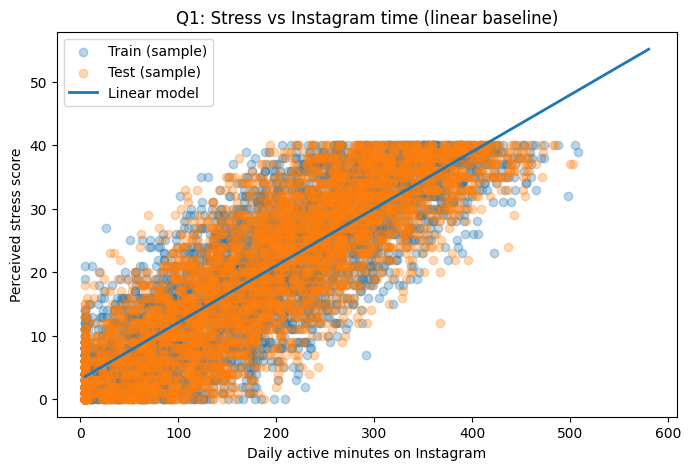

In [8]:
# 1C) Plot: real points (train/test) + regression line (sampled)
# Plot sample to keep it readable
train_plot = X_train.copy()
train_plot["y"] = y_train
train_plot = train_plot.sample(min(SAMPLE_ROWS_PLOT, len(train_plot)), random_state=RANDOM_STATE)

test_plot = X_test.copy()
test_plot["y"] = y_test
test_plot = test_plot.sample(min(SAMPLE_ROWS_PLOT, len(test_plot)), random_state=RANDOM_STATE)

plt.figure(figsize=(8,5))
plt.scatter(train_plot[MAIN_X], train_plot["y"], alpha=0.3, label="Train (sample)")
plt.scatter(test_plot[MAIN_X], test_plot["y"], alpha=0.3, label="Test (sample)")

# Regression line
x_line = np.linspace(df_q1[MAIN_X].min(), df_q1[MAIN_X].max(), 100)
y_line = lin.predict(pd.DataFrame({MAIN_X: x_line}))
plt.plot(x_line, y_line, linewidth=2, label="Linear model")

plt.xlabel("Daily active minutes on Instagram")
plt.ylabel("Perceived stress score")
plt.title("Q1: Stress vs Instagram time (linear baseline)")
plt.legend()
plt.show()


### Q1 (optional but stronger): add more usage features + nonlinear model

This usually improves results if the relationship isn’t purely linear.

Pick a small, defensible feature set to avoid leakage and keep it explainable.


Q1 multi-feature rows used: 200000
RandomForestRegressor (multi-feature)
Test MAE=4.966 | RMSE=6.211 | R2=0.725


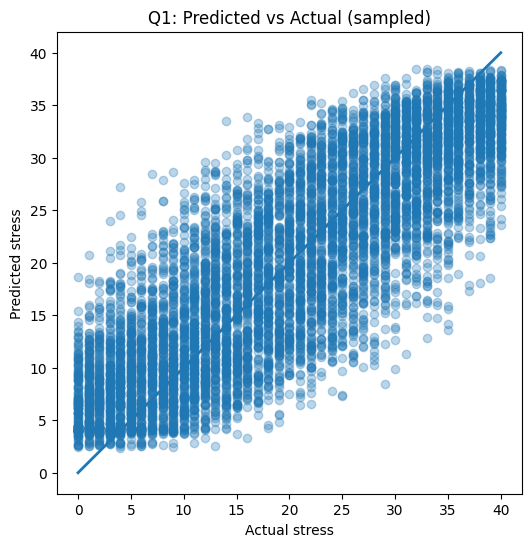

In [9]:
# 1D) Multi-feature regression with proper preprocessing
FEATURES_Q1 = [
    "daily_active_minutes_instagram",
    "sessions_per_day",
    "reels_watched_per_day",
    "stories_viewed_per_day",
    "likes_given_per_day",
    "comments_written_per_day",
    "dms_sent_per_week",
    "time_on_feed_per_day",
    "time_on_explore_per_day",
    "time_on_messages_per_day",
    "time_on_reels_per_day",
    "followers_count",
    "following_count",
    "notification_response_rate",
    "average_session_length_minutes",
    # You may add lifestyle confounders if your teacher expects it:
    # "sleep_hours_per_night", "weekly_work_hours", "exercise_hours_per_week"
]
FEATURES_Q1 = [c for c in FEATURES_Q1 if c in df.columns]

df_q1m = df[FEATURES_Q1 + [TARGET]].dropna()
# Sample rows for speed (keeps results stable on 1M+ rows)
if len(df_q1m) > SAMPLE_ROWS_MODEL:
    df_q1m = df_q1m.sample(SAMPLE_ROWS_MODEL, random_state=RANDOM_STATE)
print('Q1 multi-feature rows used:', len(df_q1m))
X = df_q1m[FEATURES_Q1]
y = df_q1m[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

preprocessor, num_cols, cat_cols = build_preprocessor(df_q1m, FEATURES_Q1)

rf = RandomForestRegressor(
    n_estimators=120,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=18,
    min_samples_leaf=20,
    max_features=0.6,
    max_samples=0.25
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

model.fit(X_train, y_train)
pred_test = model.predict(X_test)

print("RandomForestRegressor (multi-feature)")
regression_report(y_test, pred_test, "Test")

# Predicted vs Actual plot
sample = min(8000, len(X_test))
idx = np.random.RandomState(RANDOM_STATE).choice(len(X_test), size=sample, replace=False)

plt.figure(figsize=(6,6))
plt.scatter(y_test.iloc[idx], pred_test[idx], alpha=0.3)
plt.xlabel("Actual stress")
plt.ylabel("Predicted stress")
plt.title("Q1: Predicted vs Actual (sampled)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=2)
plt.show()


# Question 2
## Predict age based on usage (minutes, reels, stories)

Target: `age`  
Predictors: usage + engagement features

Deliver:
- Regression baseline and improved model
- MAE/RMSE/R2
- Feature importance (what behaviors correlate with age)


Q2 rows used: 200000
Q2 Age prediction
Test MAE=7.507 | RMSE=9.105 | R2=0.646


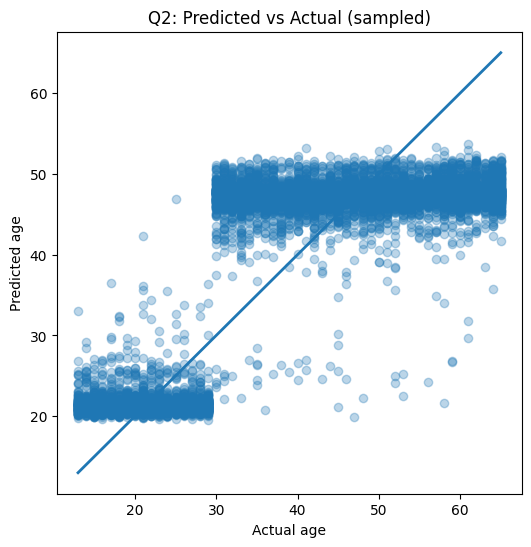

In [10]:
TARGET = "age"

FEATURES_Q2 = [
    # Numeric usage features (fast + strong)
    "daily_active_minutes_instagram",
    "reels_watched_per_day",
    "stories_viewed_per_day",
    "time_on_reels_per_day",
    "time_on_feed_per_day",
    "sessions_per_day",
    "average_session_length_minutes",
    "likes_given_per_day",
    "comments_written_per_day",
    "followers_count",
    "following_count",
    # Optional categoricals (can slow down if many unique values):
    # "content_type_preference",
    # "preferred_content_theme",
]
FEATURES_Q2 = [c for c in FEATURES_Q2 if c in df.columns]

df_q2 = df[FEATURES_Q2 + [TARGET]].dropna()
if len(df_q2) > SAMPLE_ROWS_MODEL:
    df_q2 = df_q2.sample(SAMPLE_ROWS_MODEL, random_state=RANDOM_STATE)
print('Q2 rows used:', len(df_q2))
X = df_q2[FEATURES_Q2]
y = df_q2[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

preprocessor, _, _ = build_preprocessor(df_q2, FEATURES_Q2)

rf = RandomForestRegressor(
    n_estimators=120,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_depth=18,
    min_samples_leaf=20,
    max_features=0.6,
    max_samples=0.25
)

pipe = Pipeline([("preprocess", preprocessor), ("model", rf)])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Q2 Age prediction")
regression_report(y_test, pred, "Test")

# Plot: Predicted vs Actual (sampled)
sample = min(8000, len(X_test))
idx = np.random.RandomState(RANDOM_STATE).choice(len(X_test), size=sample, replace=False)
plt.figure(figsize=(6,6))
plt.scatter(y_test.iloc[idx], pred[idx], alpha=0.3)
plt.xlabel('Actual age')
plt.ylabel('Predicted age')
plt.title('Q2: Predicted vs Actual (sampled)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linewidth=2)
plt.show()


# Question 3
## What information do we need to predict ads viewed / clicked?

Targets: `ads_viewed_per_day`, `ads_clicked_per_day`  
Approach:
- Train a model for each target
- Use **permutation importance** to rank which features matter most
Deliver:
- Top 10 important features for ads viewed and ads clicked


ads_viewed_per_day Test MAE=3.481 | RMSE=4.474 | R2=0.796


,importance
daily_active_minutes_instagram,0.761278
time_on_feed_per_day,0.062709
time_on_reels_per_day,0.009674
time_on_explore_per_day,0.000695
user_engagement_score,0.000133
linked_accounts_count,0.000021
sessions_per_day,0.000007
followers_count,-0.000044
average_session_length_minutes,-0.000054
following_count,-0.000072


ads_clicked_per_day Test MAE=1.687 | RMSE=2.181 | R2=0.506


,importance
daily_active_minutes_instagram,0.456532
time_on_feed_per_day,0.043290
time_on_reels_per_day,0.005492
time_on_explore_per_day,0.000338
linked_accounts_count,0.000267
notification_response_rate,0.000179
followers_count,0.000113
user_engagement_score,0.000037
sessions_per_day,-0.000176
following_count,-0.000221


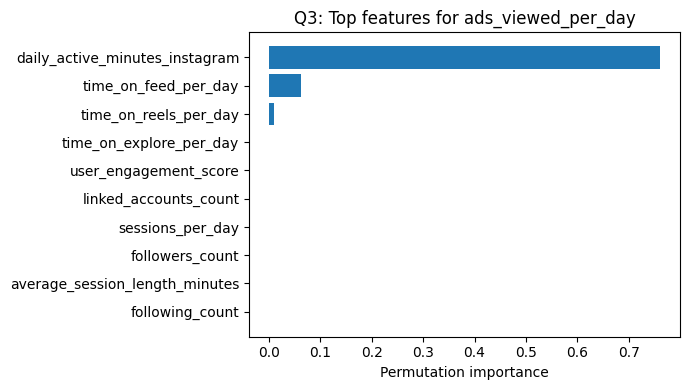

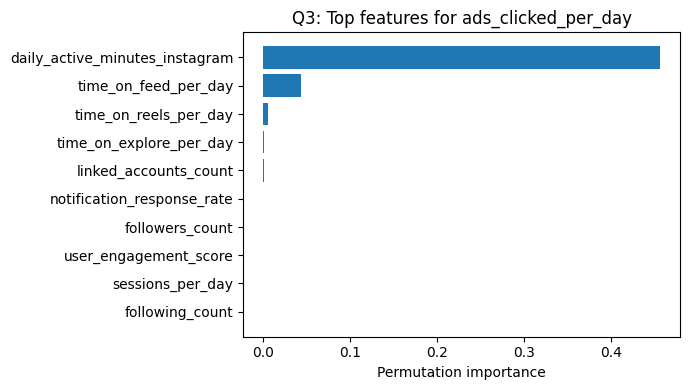

In [11]:
def top_features_for_target(target_col, feature_cols, sample_rows=200_000):
    cols = [c for c in feature_cols if c in df.columns] + [target_col]
    d = df[cols].dropna()
    if len(d) > sample_rows:
        d = d.sample(sample_rows, random_state=RANDOM_STATE)

    X = d[feature_cols]
    y = d[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    preprocessor, _, _ = build_preprocessor(d, feature_cols)

    model = RandomForestRegressor(
        n_estimators= 120,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_depth=18,
        min_samples_leaf=20,
        max_features=0.6,
        max_samples=0.25
    )
    pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    regression_report(y_test, pred, f"{target_col} Test")

    # Permutation importance on a small subsample of test for speed
    X_test_small = X_test.sample(min(15_000, len(X_test)), random_state=RANDOM_STATE)
    y_test_small = y_test.loc[X_test_small.index]

    r = permutation_importance(pipe, X_test_small, y_test_small, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
    importances = pd.Series(r.importances_mean, index=feature_cols).sort_values(ascending=False)
    return importances

FEATURES_Q3 = [
    # Numeric behavior/engagement features (fast)
    "daily_active_minutes_instagram",
    "sessions_per_day",
    "time_on_feed_per_day",
    "time_on_explore_per_day",
    "time_on_reels_per_day",
    "notification_response_rate",
    "average_session_length_minutes",
    "user_engagement_score",
    "followers_count",
    "following_count",
    "linked_accounts_count",
    # Optional categoricals (may slow down if many unique values):
    # "subscription_status",
    # "uses_premium_features",
    # "content_type_preference",
    # "preferred_content_theme",
    # "privacy_setting_level",
]
FEATURES_Q3 = [c for c in FEATURES_Q3 if c in df.columns]

imp_viewed = top_features_for_target("ads_viewed_per_day", FEATURES_Q3)
display(imp_viewed.head(10).to_frame("importance"))

imp_clicked = top_features_for_target("ads_clicked_per_day", FEATURES_Q3)
display(imp_clicked.head(10).to_frame("importance"))

# Plot top 10 importances (ads viewed)
top10 = imp_viewed.head(10).sort_values()
plt.figure(figsize=(7,4))
plt.barh(top10.index, top10.values)
plt.title('Q3: Top features for ads_viewed_per_day')
plt.xlabel('Permutation importance')
plt.tight_layout()
plt.show()

# Plot top 10 importances (ads clicked)
top10c = imp_clicked.head(10).sort_values()
plt.figure(figsize=(7,4))
plt.barh(top10c.index, top10c.values)
plt.title('Q3: Top features for ads_clicked_per_day')
plt.xlabel('Permutation importance')
plt.tight_layout()
plt.show()


# Question 4
## Influence of creating many posts on user behavior (quartiles)

Idea:
- Split users into quartiles by `posts_created_per_week`
- Compare engagement metrics (minutes, likes, comments, ads clicked, etc.)

Deliver:
- Table of averages/medians by quartile
- A simple plot for 2–3 key metrics


daily_active_minutes_instagram        user_engagement_score  \
                                           mean median                  mean   
creator_quartile                                                               
Q1 low                                  116.806  115.0                 2.013   
Q2                                      167.961  160.0                 1.820   
Q3                                      228.719  239.0                 1.392   
Q4 heavy                                260.860  264.0                 1.251   

                        likes_given_per_day        comments_written_per_day  \
                 median                mean median                     mean   
creator_quartile                                                              
Q1 low             1.18              83.382   82.0                   23.513   
Q2                 1.11             108.971  105.0                   31.195   
Q3                 1.05             139.365  144.0                   40.278   
Q4 heavy           1.07             155.449  157.0                   45.078   

                        ads_viewed_per_day        ads_clicked_per_day         
                 median               mean median                mean median  
creator_quartile                                                              
Q1 low             23.0             14.350   14.0               3.333    3.0  
Q2                 30.0             18.427   17.0               4.362    4.0  
Q3                 41.0             23.287   24.0               5.575    5.0  
Q4 heavy           45.0             25.850   26.0               6.219    6.0

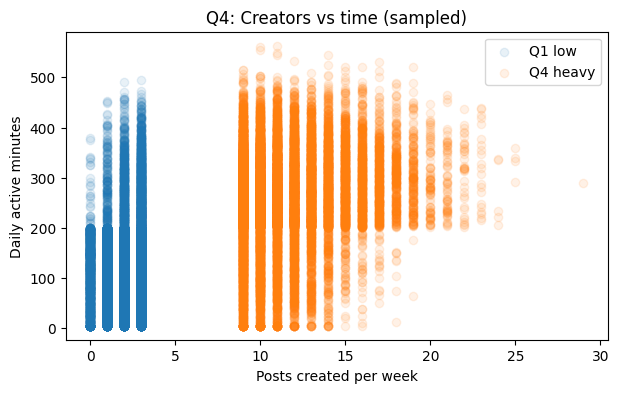

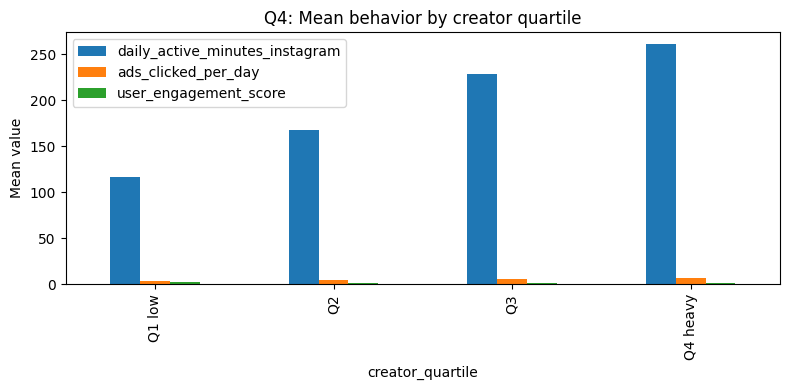

In [12]:
creator_col = "posts_created_per_week"
metrics = [
    "daily_active_minutes_instagram",
    "user_engagement_score",
    "likes_given_per_day",
    "comments_written_per_day",
    "ads_viewed_per_day",
    "ads_clicked_per_day",
]
cols = [creator_col] + [c for c in metrics if c in df.columns]
d = df[cols].dropna()

# Quartiles
d["creator_quartile"] = pd.qcut(d[creator_col], 4, labels=["Q1 low", "Q2", "Q3", "Q4 heavy"])

summary = d.groupby("creator_quartile")[metrics].agg(["mean", "median"]).round(3)
display(summary)

# Plot (sample)
sample = d.sample(min(80_000, len(d)), random_state=RANDOM_STATE)

plt.figure(figsize=(7,4))
for q in ["Q1 low", "Q4 heavy"]:
    s = sample[sample["creator_quartile"] == q]
    plt.scatter(s[creator_col], s["daily_active_minutes_instagram"], alpha=0.1, label=q)
plt.xlabel("Posts created per week")
plt.ylabel("Daily active minutes")
plt.title("Q4: Creators vs time (sampled)")
plt.legend()
plt.show()

# Bar chart: quartile means for key metrics
quart_means = d.groupby('creator_quartile')[['daily_active_minutes_instagram','ads_clicked_per_day','user_engagement_score']].mean(numeric_only=True)
quart_means = quart_means.reindex(['Q1 low','Q2','Q3','Q4 heavy'])
quart_means.plot(kind='bar', figsize=(8,4))
plt.title('Q4: Mean behavior by creator quartile')
plt.ylabel('Mean value')
plt.tight_layout()
plt.show()


# Question 5
## Profile the people who click the most on ads

Define “top clickers”:
- Top 10% of `ads_clicked_per_day` (or top 5%)

Deliver:
- Demographics profile (age, gender, income_level, education_level, country)
- Behavior profile (minutes, sessions, engagement score, etc.)


In [13]:
target = "ads_clicked_per_day"
profile_cols = [
    "age", "gender", "country", "income_level", "education_level", "relationship_status",
    "daily_active_minutes_instagram", "sessions_per_day", "user_engagement_score",
    "reels_watched_per_day", "stories_viewed_per_day", "followers_count", "following_count",
    "subscription_status", "uses_premium_features"
]
profile_cols = [c for c in profile_cols if c in df.columns] + [target]

d = df[profile_cols].dropna(subset=[target])
threshold = d[target].quantile(0.90)
d["top_clicker"] = (d[target] >= threshold).astype(int)

print("Top clicker threshold (90th percentile):", threshold)
print("Top clickers:", d["top_clicker"].mean())

# Numeric summary
num_cols = d.select_dtypes(include=[np.number]).columns
display(d.groupby("top_clicker")[num_cols].median().T.sort_values(1, ascending=False).head(20))

# Categorical distribution
for c in ["gender", "income_level", "education_level", "country", "relationship_status"]:
    if c in d.columns:
        dist = (d[d["top_clicker"]==1][c].value_counts(normalize=True).head(10)).to_frame("top_clickers_share")
        display(dist)


Top clicker threshold (90th percentile): 9.0
Top clickers: 0.12470217637360649


top_clicker,0,1
following_count,1494.00,1703.00
followers_count,1135.00,1295.00
daily_active_minutes_instagram,167.00,316.00
reels_watched_per_day,163.00,256.00
stories_viewed_per_day,96.00,150.00
age,40.00,34.00
sessions_per_day,8.00,15.00
ads_clicked_per_day,4.00,10.00
top_clicker,0.00,1.00
user_engagement_score,1.12,0.99


,top_clickers_share
gender,
Female,0.480883
Male,0.479511
Non-binary,0.029789
Prefer not to say,0.009817


,top_clickers_share
income_level,
Middle,0.298385
Lower-middle,0.249479
Low,0.200916
Upper-middle,0.150669
High,0.100551


,top_clickers_share
education_level,
Bachelor’s,0.349637
High school,0.251567
Some college,0.199274
Master’s,0.119274
Other,0.050351
PhD,0.029898


,top_clickers_share
country,
United States,0.249661
India,0.180603
Brazil,0.119813
Other,0.099681
United Kingdom,0.080471
Canada,0.069856
Australia,0.059261
Germany,0.050475
South Korea,0.050351


,top_clickers_share
relationship_status,
Single,0.398371
Married,0.251018
In a relationship,0.249894
Divorced,0.080533
Widowed,0.020184


# Question 6
## Predict income based on education level

If `income_level` is categorical (common), do **classification**.

Deliver:
- Baseline: predict the most frequent class
- Model using only education_level (and optionally add other safe predictors)
- Metrics: accuracy / F1 (and ROC-AUC only if binary)


In [14]:
TARGET = "income_level"
FEATURES_Q6 = ["education_level"]  # teacher’s question focuses here
FEATURES_Q6 = [c for c in FEATURES_Q6 if c in df.columns]

if TARGET in df.columns and FEATURES_Q6:
    d = df[FEATURES_Q6 + [TARGET]].dropna()
    X = d[FEATURES_Q6]
    y = d[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    preprocessor, _, _ = build_preprocessor(d, FEATURES_Q6)

    # Multiclass logistic regression baseline (interpretable)
    clf = LogisticRegression(max_iter=2000, n_jobs=-1)
    pipe = Pipeline([("preprocess", preprocessor), ("model", clf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    print("Q6 Income level from education_level")
    classification_report_basic(y_test, pred, label="Test")
else:
    print("Missing TARGET or FEATURES_Q6 in dataset.")


/home/khris/Documents/insta/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Q6 Income level from education_level
Test Accuracy=0.300 | F1(weighted)=0.139
Confusion matrix:
[[    0     0     0 30912     0]
 [    0     0     0 61947     0]
 [    0     0     0 77363     0]
 [    0     0     0 93008     0]
 [    0     0     0 46350     0]]

Classification report:


/home/khris/Documents/insta/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/khris/Documents/insta/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

        High       0.00      0.00      0.00     30912
         Low       0.00      0.00      0.00     61947
Lower-middle       0.00      0.00      0.00     77363
      Middle       0.30      1.00      0.46     93008
Upper-middle       0.00      0.00      0.00     46350

    accuracy                           0.30    309580
   macro avg       0.06      0.20      0.09    309580
weighted avg       0.09      0.30      0.14    309580



/home/khris/Documents/insta/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Question 7
## Predict a user’s relationship status

This is a **classification** problem.

Deliver:
- Choose a clean set of predictors (demographics + behavior)
- Train/test metrics + confusion matrix
- Note: relationship status can be sensitive; keep features defensible.


In [15]:
TARGET = "relationship_status"
FEATURES_Q7 = [
    "age", "gender", "has_children", "employment_status", "education_level", "income_level",
    "daily_active_minutes_instagram", "sessions_per_day", "user_engagement_score",
    "ads_viewed_per_day", "ads_clicked_per_day"
]
FEATURES_Q7 = [c for c in FEATURES_Q7 if c in df.columns]

if TARGET in df.columns and FEATURES_Q7:
    d = df[FEATURES_Q7 + [TARGET]].dropna()
    X = d[FEATURES_Q7]
    y = d[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    preprocessor, _, _ = build_preprocessor(d, FEATURES_Q7)

    clf = RandomForestClassifier(
        n_estimators=120, random_state=RANDOM_STATE, n_jobs=-1
    )

    pipe = Pipeline([("preprocess", preprocessor), ("model", clf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    print("Q7 Relationship status prediction")
    classification_report_basic(y_test, pred, label="Test")
else:
    print("Missing TARGET or FEATURES_Q7 in dataset.")


Q7 Relationship status prediction
Test Accuracy=0.362 | F1(weighted)=0.294
Confusion matrix:
[[   76  3140  3048 18445     9]
 [  273 10046  9793 57283    22]
 [  306 10026  9907 57157    33]
 [  446 15814 15629 91915    44]
 [   28   759   791  4587     3]]

Classification report:
                   precision    recall  f1-score   support

         Divorced       0.07      0.00      0.01     24718
In a relationship       0.25      0.13      0.17     77417
          Married       0.25      0.13      0.17     77429
           Single       0.40      0.74      0.52    123848
          Widowed       0.03      0.00      0.00      6168

         accuracy                           0.36    309580
        macro avg       0.20      0.20      0.17    309580
     weighted avg       0.29      0.36      0.29    309580



# Question 8
## Profile the wealthiest users

Interpretation:
- If `income_level` is categorical, define “wealthiest” = highest bucket.
- If income is numeric (not listed), use top quantile.

Deliver:
- Demographics, behaviors, and health/lifestyle summary for wealthiest group vs rest.


In [16]:
if "income_level" in df.columns:
    d = df.copy()
    # If income_level has clear ordering like Low/Medium/High, you can map it.
    # Otherwise, take the top category by median engagement or define explicitly.
    top_cat = d["income_level"].value_counts().index[0]  # placeholder

    # Better: choose the category that looks like "High" if present
    for candidate in ["High", "high", "Top", "Wealthy", "Very High"]:
        if candidate in d["income_level"].astype(str).unique():
            top_cat = candidate
            break

    d["is_wealthy"] = (d["income_level"].astype(str) == str(top_cat)).astype(int)
    print("Wealthy category assumed as:", top_cat)

    cols = [
        "age","gender","country","education_level","employment_status","relationship_status",
        "daily_active_minutes_instagram","user_engagement_score","ads_clicked_per_day",
        "followers_count","following_count","sleep_hours_per_night","weekly_work_hours"
    ]
    cols = [c for c in cols if c in d.columns]
    display(d.groupby("is_wealthy")[cols].median(numeric_only=True).T.sort_values(1, ascending=False).head(20))
else:
    print("No income_level column found.")


Wealthy category assumed as: High


is_wealthy,0,1
following_count,1518.0,1522.0
followers_count,1154.0,1153.0
daily_active_minutes_instagram,186.0,187.0
weekly_work_hours,40.0,40.0
age,39.0,39.0
sleep_hours_per_night,7.0,7.0
ads_clicked_per_day,4.0,4.0
user_engagement_score,1.1,1.1


# Question 9
## Propose different personas to classify users

Approach:
- Select meaningful features (usage + engagement + basic demographics)
- Standardize numeric features and one-hot encode categoricals
- Use clustering (KMeans) and pick K with silhouette (optional)

Deliver:
- 4–8 personas with names + descriptions based on cluster centers.


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

FEATURES_Q9 = [
    "age","gender","income_level",
    "daily_active_minutes_instagram","sessions_per_day","average_session_length_minutes",
    "reels_watched_per_day","stories_viewed_per_day","likes_given_per_day","comments_written_per_day",
    "posts_created_per_week","ads_viewed_per_day","ads_clicked_per_day",
    "user_engagement_score","subscription_status","uses_premium_features"
]
FEATURES_Q9 = [c for c in FEATURES_Q9 if c in df.columns]

d = df[FEATURES_Q9].dropna()

# Sample for clustering if huge
if len(d) > SAMPLE_ROWS_CLUSTER:
    d = d.sample(SAMPLE_ROWS_CLUSTER, random_state=RANDOM_STATE)

preprocessor, _, _ = build_preprocessor(d, FEATURES_Q9)

X_prep = preprocessor.fit_transform(d[FEATURES_Q9])

# Choose K quickly (optional)
Ks = [4,5,6,7,8]
scores = {}
for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_prep)
    scores[k] = silhouette_score(X_prep, labels)

display(pd.Series(scores, name="silhouette").sort_values(ascending=False))

BEST_K = max(scores, key=scores.get)
print("Chosen K:", BEST_K)

km = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=10)
persona = km.fit_predict(X_prep)

d_persona = d.copy()
d_persona["persona"] = persona

# Persona summaries (medians)
num_cols = d_persona.select_dtypes(include=[np.number]).columns
display(d_persona.groupby("persona")[num_cols].median().round(2))


4    0.179438
5    0.174875
6    0.159841
7    0.141730
8    0.140965
Name: silhouette, dtype: float64

Chosen K: 4


,age,daily_active_minutes_instagram,sessions_per_day,average_session_length_minutes,reels_watched_per_day,stories_viewed_per_day,likes_given_per_day,comments_written_per_day,posts_created_per_week,ads_viewed_per_day,ads_clicked_per_day,user_engagement_score,persona
persona,,,,,,,,,,,,,
0,44.0,94.0,4.0,21.5,108.0,67.0,71.0,19.0,3.0,12.0,2.0,1.31,0.0
1,29.0,319.0,16.0,19.9,271.0,150.0,185.0,54.0,9.0,31.0,8.0,1.00,1.0
2,39.0,207.0,10.0,22.2,186.0,113.0,128.0,37.0,6.0,21.0,5.0,1.06,2.0
3,49.0,5.0,1.0,5.0,45.0,32.0,28.0,7.0,3.0,5.0,1.0,8.17,3.0


# Question 10
## Minimum information required to classify someone into one of our personas

Method:
1. Train a model to predict the persona label from all features
2. Rank features by permutation importance
3. Add features progressively until accuracy reaches your target (e.g., 80%)

Deliver:
- “Top minimal features” list
- Accuracy curve by number of features


,importance
daily_active_minutes_instagram,0.126960
reels_watched_per_day,0.037733
user_engagement_score,0.028867
ads_clicked_per_day,0.028307
ads_viewed_per_day,0.023227
stories_viewed_per_day,0.022627
sessions_per_day,0.020387
likes_given_per_day,0.017267
posts_created_per_week,0.016173
age,0.015453


,n_features,accuracy
0,2,0.891133
1,4,0.927767
2,6,0.943233
3,8,0.963167
4,10,0.970900
5,12,0.971533
6,14,0.970500
7,16,0.968800


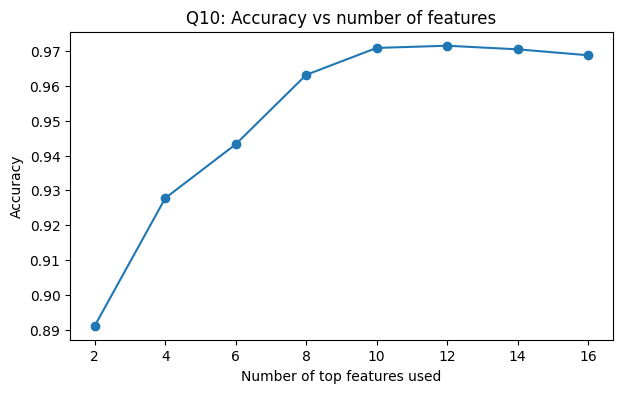

Minimum features to reach >= 80% accuracy: 2
Minimal feature list: ['daily_active_minutes_instagram', 'reels_watched_per_day']


In [18]:
from sklearn.base import clone

# Use the same d_persona created above
if "persona" not in locals():
    raise RuntimeError("Run Question 9 first to create persona labels.")

FEATURES_Q10 = FEATURES_Q9
target = "persona"

d = d_persona[FEATURES_Q10 + [target]].dropna()

X = d[FEATURES_Q10]
y = d[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

preprocessor, _, _ = build_preprocessor(d, FEATURES_Q10)

clf = RandomForestClassifier(n_estimators=120, random_state=RANDOM_STATE, n_jobs=-1)
pipe = Pipeline([("preprocess", preprocessor), ("model", clf)])
pipe.fit(X_train, y_train)

# Importance
X_test_small = X_test.sample(min(15_000, len(X_test)), random_state=RANDOM_STATE)
y_test_small = y_test.loc[X_test_small.index]
r = permutation_importance(pipe, X_test_small, y_test_small, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
imp = pd.Series(r.importances_mean, index=FEATURES_Q10).sort_values(ascending=False)
display(imp.head(20).to_frame("importance"))

# Progressive feature set
ordered = imp.index.tolist()
accs = []
steps = list(range(2, min(21, len(ordered))+1, 2))

for n in steps:
    feats = ordered[:n]
    d2 = d[feats + [target]].dropna()
    X2 = d2[feats]
    y2 = d2[target]

    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=RANDOM_STATE, stratify=y2
    )

    pre2, _, _ = build_preprocessor(d2, feats)
    pipe2 = Pipeline([("preprocess", pre2), ("model", clone(clf))])
    pipe2.fit(X2_train, y2_train)
    pred2 = pipe2.predict(X2_test)
    accs.append(accuracy_score(y2_test, pred2))

curve = pd.DataFrame({"n_features": steps, "accuracy": accs})
display(curve)

plt.figure(figsize=(7,4))
plt.plot(curve["n_features"], curve["accuracy"], marker="o")
plt.xlabel("Number of top features used")
plt.ylabel("Accuracy")
plt.title("Q10: Accuracy vs number of features")
plt.show()

# Minimal set for a target accuracy (adjust threshold)
TARGET_ACC = 0.80
hit = curve[curve["accuracy"] >= TARGET_ACC].head(1)
if len(hit):
    n_min = int(hit["n_features"].iloc[0])
    print(f"Minimum features to reach >= {TARGET_ACC:.0%} accuracy: {n_min}")
    print("Minimal feature list:", ordered[:n_min])
else:
    print(f"Did not reach {TARGET_ACC:.0%} accuracy with tested feature counts.")


# Final report section (you fill in after running)

Copy/paste your key numbers here:
- Q1: Pearson r, Linear regression metrics, better model metrics, key conclusion
- Q2: Age model metrics + top drivers
- Q3: Top features for ads viewed/clicked
- Q4: Quartile comparison (what changes when posting more)
- Q5: Top clicker profile
- Q6: Income from education (performance + what it means)
- Q7: Relationship status prediction performance + key drivers
- Q8: Wealthiest profile
- Q9: Persona names + descriptions
- Q10: Minimal features list + accuracy threshold
